In [23]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.wkt import loads

### Flooded_threshold = 0.2m

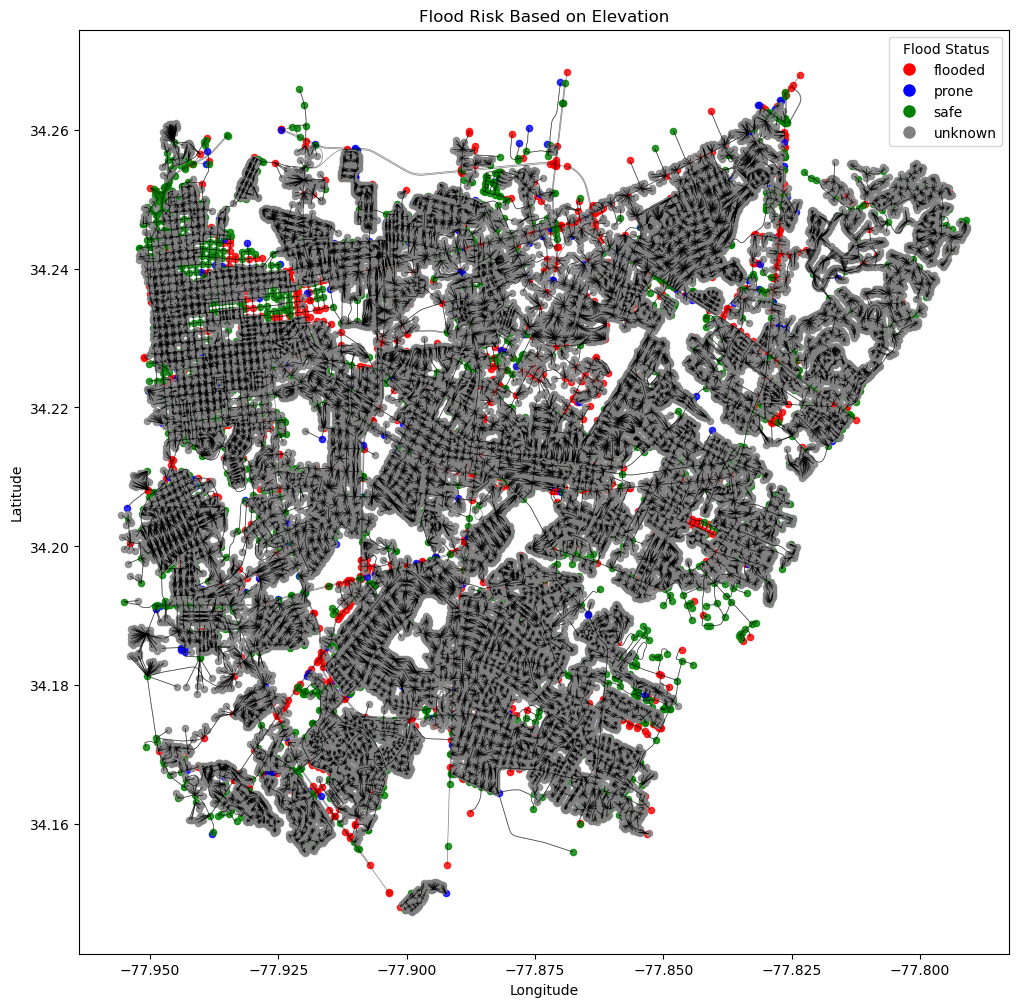

In [47]:
# Define thresholds and color mapping
flooded_threshold = 0.2  # Elevation <= 0.7 meters are considered flooded

prone_threshold = 0.7   # Elevation between 0.2 and 0.7 meters are prone to flooding

node_color_map = {
    'flooded': 'red',
    'prone': 'blue',
    'safe': 'green',
    'unknown': 'gray'
}

# Function to classify nodes based on elevation
def classify_node_by_elevation(elevation):
    if np.isnan(elevation):
        return 'unknown'  # Handle NaN values
    elif elevation <= flooded_threshold:
        return 'flooded'
   # elif flooded_threshold < elevation <= less_flooded_threshold:
        #return 'less_flooded'  # New classification for less flooded areas
    elif flooded_threshold < elevation <= prone_threshold:
        return 'prone'
    else:
        return 'safe'

# Load the CSV files
nodes_df = pd.read_csv('./data/node.csv', encoding='ISO-8859-1', low_memory=False)
links_df = pd.read_csv('./data/link.csv', encoding='ISO-8859-1', low_memory=False)

# Convert geometry column to shapely objects if they are strings
if isinstance(nodes_df['geometry'].iloc[0], str):
    nodes_df['geometry'] = nodes_df['geometry'].apply(loads)
if isinstance(links_df['geometry'].iloc[0], str):
    links_df['geometry'] = links_df['geometry'].apply(loads)

# Convert DataFrames to GeoDataFrames
Wilmington_drive_node= gpd.GeoDataFrame(nodes_df, geometry='geometry')
Wilmington_drive_edge = gpd.GeoDataFrame(links_df, geometry='geometry')


# Now you can apply this function to classify the nodes
Wilmington_drive_node['flood_status'] = Wilmington_drive_node['elevation'].apply(classify_node_by_elevation)
Wilmington_drive_node['color'] = Wilmington_drive_node['flood_status'].map(node_color_map)


# # Load the CSV file into a DataFrame (assuming it contains columns for 'elevation' and 'osmid')
# csv_file = 'Wilmington_drive_edge.csv'  # Replace with the actual CSV file path
# #san_drive_node = pd.read_csv(csv.file)

# # Apply classification
# Wilmington_drive_node['flood_status'] = Wilmington_drive_node['elevation'].apply(classify_node_by_elevation)
# Wilmington_drive_node['color'] = Wilmington_drive_node['flood_status'].map(node_color_map)

# Extract the flooded data
flooded_data = Wilmington_drive_node

# Save the flooded data to a new CSV file (optional)
flooded_data.to_csv('./data/0.2m/Node flooded 0.2.csv', index=False)

# Plotting function
def plot_flooded_areas():
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the road network (background)
    Wilmington_drive_edge.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5, label='Road Network')

    # Plot the nodes color-coded by flood status
    for status, color in node_color_map.items():
        subset = Wilmington_drive_node[Wilmington_drive_node['flood_status'] == status]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=20, alpha=0.8, label=status)

    # Set aspect ratio to auto to avoid errors
    ax.set_aspect('auto')

    # Add title and labels
    plt.title("Flood Risk Based on Elevation")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Create custom legend handles
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=status)
               for status, color in node_color_map.items()]

    # Add the legend to the plot
    ax.legend(handles=handles, title="Flood Status", loc='upper right')
# Call the function to plot
plot_flooded_areas()
# plt.savefig("Flood Risk Based on Elevation_flooded_threshold_0.2 = 1.png")

# Show the plot
plt.show()

In [33]:
# Function to classify edges based on flood risk
def label_flood_risk(df, threshold):
    """
    Labels each edge in the dataframe based on the elevation of u and v endpoints.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing 'elevation_from' and 'elevation_to' columns.
    threshold : float
        The elevation threshold below which nodes are considered flooded.

    Returns:
    pandas.DataFrame
        DataFrame with a new column 'flood_risk' indicating flood status.
    """
    def classify_edge(elevation_from, elevation_to):
        if elevation_from < threshold and elevation_to < threshold:
            return 'flooded'
        elif elevation_from >= threshold and elevation_to >= threshold:
            return 'safe'
        else:
            return 'partially-flooded'

    # Apply classification to each row
    df['flood_risk'] = df.apply(lambda row: classify_edge(row['elevation_from'], row['elevation_to']), axis=1)
    return df

# Apply the labeling function
Wilmington_drive_edge = label_flood_risk(Wilmington_drive_edge, threshold=0.2)

# Remove duplicate osmid columns (if any)
if 'osmid_x' in Wilmington_drive_edge.columns:
    Wilmington_drive_edge['osmid'] = Wilmington_drive_edge['osmid_x']
    Wilmington_drive_edge = Wilmington_drive_edge.drop(columns=['osmid_x', 'osmid_y'], errors='ignore')
elif 'osmid_y' in Wilmington_drive_edge.columns:
    Wilmington_drive_edge['osmid'] = Wilmington_drive_edge['osmid_y']
    Wilmington_drive_edge = Wilmington_drive_edge.drop(columns=['osmid_x', 'osmid_y'], errors='ignore')

# Final DataFrame with the flood risk and osmid
print(Wilmington_drive_edge.head())


#Output the files
# Save the classified nodes with their attributes to a CSV file
output_csv_link_file = './data/0.2m/link.csv'
output_csv_node_file = './data/0.2m/node.csv'

# Select the relevant columns that exist in the DataFrame
Wilmington_drive_edge.to_csv(output_csv_link_file, index=False)
Wilmington_drive_node.to_csv(output_csv_node_file, index=False)


# Confirm the file has been saved
print(f"File saved as {output_csv_link_file}")
print(f"File saved as {output_csv_node_file}")



               name  link_id  osm_way_id  from_node_id  to_node_id  dir_flag  \
0  Saint Luke Court        0  16680595.0             0           1         1   
1  Saint Luke Court        1  16680595.0             1           0         1   
2  Saint Luke Court        2  16680595.0             1           2         1   
3  Saint Luke Court        3  16680595.0             2           1         1   
4  Saint Luke Court        4  16680596.0             1           3         1   

   length  Number of Lanes  free_speed  capacity  ... VDF_fftt1  VDF_cap1  \
0   46.86                1          30    1000.0  ...       NaN       NaN   
1   46.86                1          30    1000.0  ...       NaN       NaN   
2   59.57                1          30    1000.0  ...       NaN       NaN   
3   59.57                1          30    1000.0  ...       NaN       NaN   
4   31.97                1          30    1000.0  ...       NaN       NaN   

  travel_time Speed Limit  width         grade     grade

### Flooded_threshold = 1m

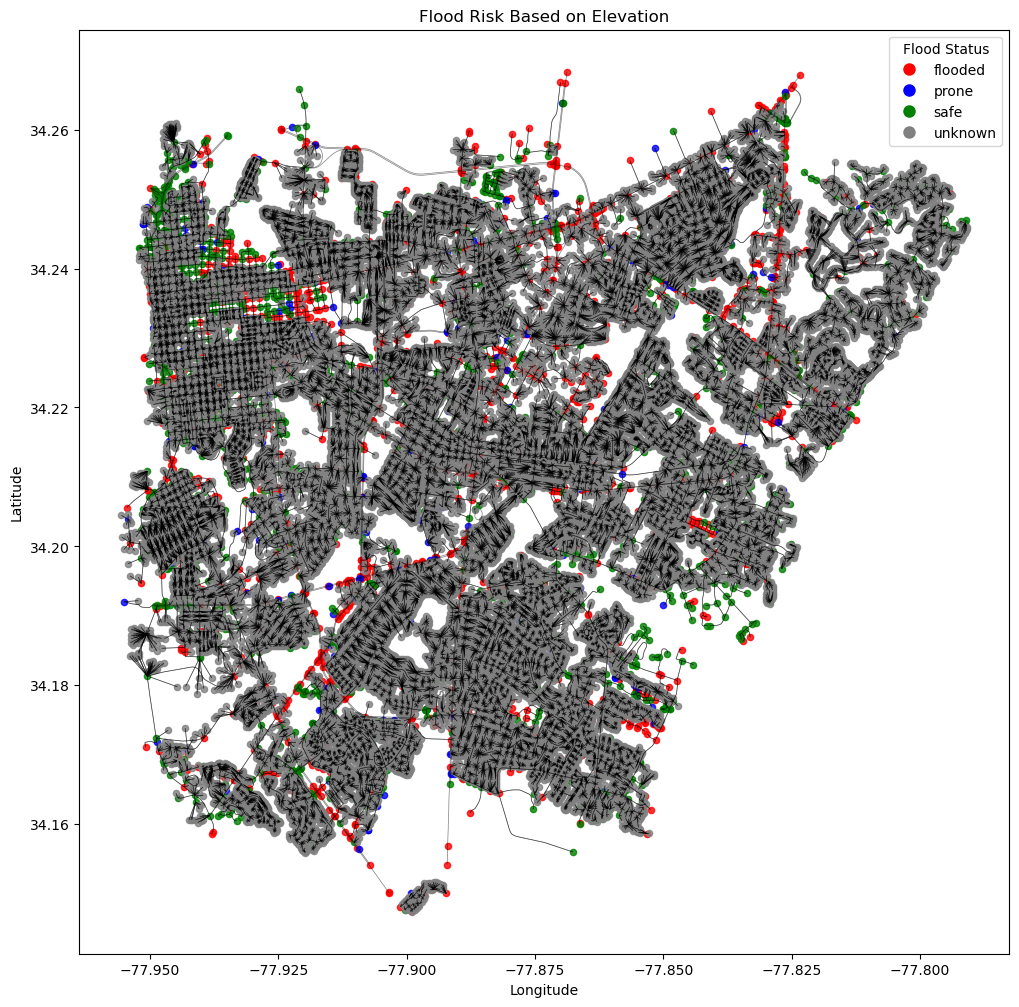

In [45]:
# Define thresholds and color mapping
flooded_threshold = 1  # Elevation <= 1 meters are considered flooded

prone_threshold = 1.5   # Elevation between 1 and 1.5 meters are prone to flooding

node_color_map = {
    'flooded': 'red',
    'prone': 'blue',
    'safe': 'green',
    'unknown': 'gray'
}

# Function to classify nodes based on elevation
def classify_node_by_elevation(elevation):
    if np.isnan(elevation):
        return 'unknown'  # Handle NaN values
    elif elevation <= flooded_threshold:
        return 'flooded'
   # elif flooded_threshold < elevation <= less_flooded_threshold:
        #return 'less_flooded'  # New classification for less flooded areas
    elif flooded_threshold < elevation <= prone_threshold:
        return 'prone'
    else:
        return 'safe'

# Load the CSV files
nodes_df = pd.read_csv('./data/node.csv', encoding='ISO-8859-1', low_memory=False)
links_df = pd.read_csv('./data/link.csv', encoding='ISO-8859-1', low_memory=False)

# Convert geometry column to shapely objects if they are strings
if isinstance(nodes_df['geometry'].iloc[0], str):
    nodes_df['geometry'] = nodes_df['geometry'].apply(loads)
if isinstance(links_df['geometry'].iloc[0], str):
    links_df['geometry'] = links_df['geometry'].apply(loads)

# Convert DataFrames to GeoDataFrames
Wilmington_drive_node= gpd.GeoDataFrame(nodes_df, geometry='geometry')
Wilmington_drive_edge = gpd.GeoDataFrame(links_df, geometry='geometry')


# Now you can apply this function to classify the nodes
Wilmington_drive_node['flood_status'] = Wilmington_drive_node['elevation'].apply(classify_node_by_elevation)
Wilmington_drive_node['color'] = Wilmington_drive_node['flood_status'].map(node_color_map)


# # Load the CSV file into a DataFrame (assuming it contains columns for 'elevation' and 'osmid')
# csv_file = 'Wilmington_drive_edge.csv'  # Replace with the actual CSV file path
# #san_drive_node = pd.read_csv(csv.file)

# # Apply classification
# Wilmington_drive_node['flood_status'] = Wilmington_drive_node['elevation'].apply(classify_node_by_elevation)
# Wilmington_drive_node['color'] = Wilmington_drive_node['flood_status'].map(node_color_map)

# Extract the flooded data
flooded_data = Wilmington_drive_node

# Save the flooded data to a new CSV file (optional)
flooded_data.to_csv('./data/1m/Node flooded 1.csv', index=False)

# Plotting function
def plot_flooded_areas():
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the road network (background)
    Wilmington_drive_edge.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5, label='Road Network')

    # Plot the nodes color-coded by flood status
    for status, color in node_color_map.items():
        subset = Wilmington_drive_node[Wilmington_drive_node['flood_status'] == status]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=20, alpha=0.8, label=status)

    # Set aspect ratio to auto to avoid errors
    ax.set_aspect('auto')

    # Add title and labels
    plt.title("Flood Risk Based on Elevation")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Create custom legend handles
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=status)
               for status, color in node_color_map.items()]

    # Add the legend to the plot
    ax.legend(handles=handles, title="Flood Status", loc='upper right')
# Call the function to plot
plot_flooded_areas()
# plt.savefig("Flood Risk Based on Elevation_flooded_threshold_0.2 = 1.png")

# Show the plot
plt.show()

In [35]:
# Function to classify edges based on flood risk
def label_flood_risk(df, threshold):
    """
    Labels each edge in the dataframe based on the elevation of u and v endpoints.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing 'elevation_from' and 'elevation_to' columns.
    threshold : float
        The elevation threshold below which nodes are considered flooded.

    Returns:
    pandas.DataFrame
        DataFrame with a new column 'flood_risk' indicating flood status.
    """
    def classify_edge(elevation_from, elevation_to):
        if elevation_from < threshold and elevation_to < threshold:
            return 'flooded'
        elif elevation_from >= threshold and elevation_to >= threshold:
            return 'safe'
        else:
            return 'partially-flooded'

    # Apply classification to each row
    df['flood_risk'] = df.apply(lambda row: classify_edge(row['elevation_from'], row['elevation_to']), axis=1)
    return df

# Apply the labeling function
Wilmington_drive_edge = label_flood_risk(Wilmington_drive_edge, threshold=1)

# Remove duplicate osmid columns (if any)
if 'osmid_x' in Wilmington_drive_edge.columns:
    Wilmington_drive_edge['osmid'] = Wilmington_drive_edge['osmid_x']
    Wilmington_drive_edge = Wilmington_drive_edge.drop(columns=['osmid_x', 'osmid_y'], errors='ignore')
elif 'osmid_y' in Wilmington_drive_edge.columns:
    Wilmington_drive_edge['osmid'] = Wilmington_drive_edge['osmid_y']
    Wilmington_drive_edge = Wilmington_drive_edge.drop(columns=['osmid_x', 'osmid_y'], errors='ignore')

# Final DataFrame with the flood risk and osmid
print(Wilmington_drive_edge.head())


#Output the files
# Save the classified nodes with their attributes to a CSV file
output_csv_link_file = './data/1m/link.csv'
output_csv_node_file = './data/m/node.csv'

# Select the relevant columns that exist in the DataFrame
Wilmington_drive_edge.to_csv(output_csv_link_file, index=False)
Wilmington_drive_node.to_csv(output_csv_node_file, index=False)


# Confirm the file has been saved
print(f"File saved as {output_csv_link_file}")
print(f"File saved as {output_csv_node_file}")



               name  link_id  osm_way_id  from_node_id  to_node_id  dir_flag  \
0  Saint Luke Court        0  16680595.0             0           1         1   
1  Saint Luke Court        1  16680595.0             1           0         1   
2  Saint Luke Court        2  16680595.0             1           2         1   
3  Saint Luke Court        3  16680595.0             2           1         1   
4  Saint Luke Court        4  16680596.0             1           3         1   

   length  Number of Lanes  free_speed  capacity  ... VDF_fftt1  VDF_cap1  \
0   46.86                1          30    1000.0  ...       NaN       NaN   
1   46.86                1          30    1000.0  ...       NaN       NaN   
2   59.57                1          30    1000.0  ...       NaN       NaN   
3   59.57                1          30    1000.0  ...       NaN       NaN   
4   31.97                1          30    1000.0  ...       NaN       NaN   

  travel_time Speed Limit  width         grade     grade

### Flooded_threshold = 2m

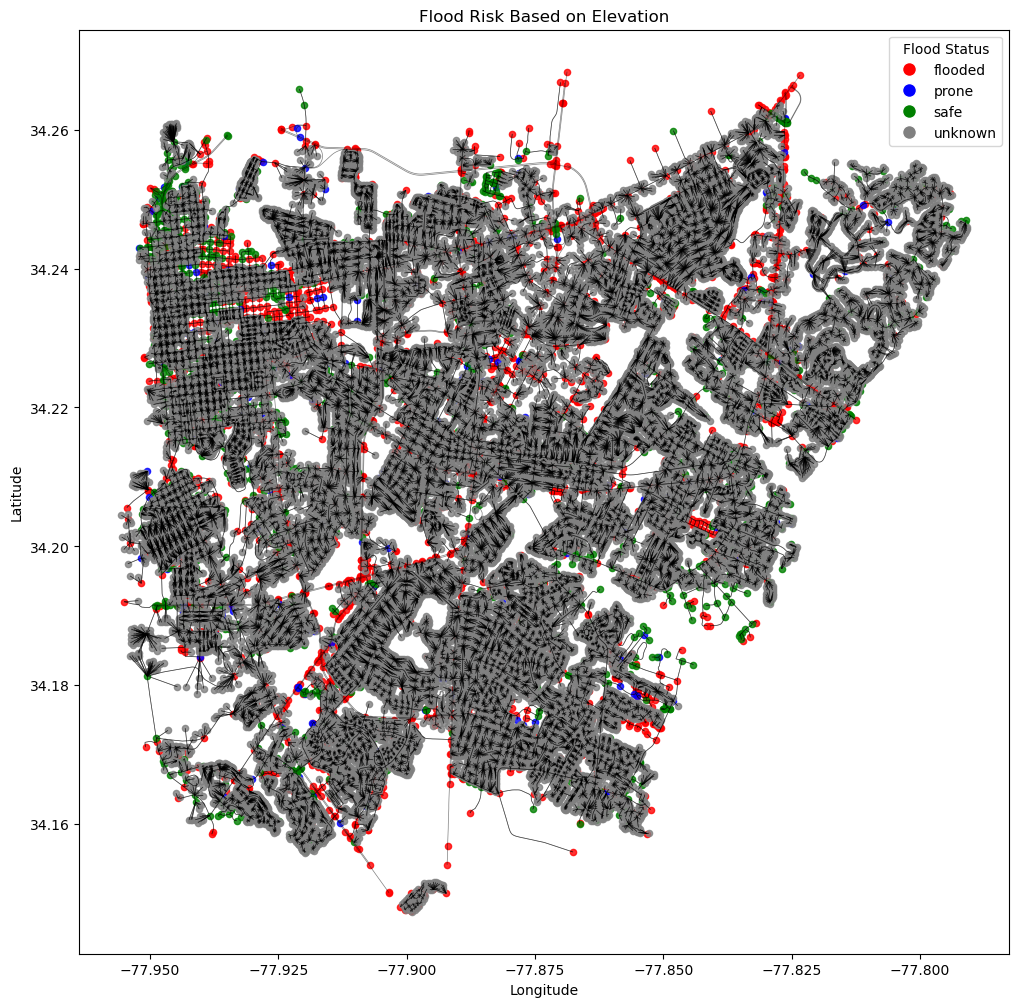

In [36]:
# Define thresholds and color mapping
flooded_threshold = 2  # Elevation <= 2 meters are considered flooded

prone_threshold = 2.5   # Elevation between 2 and 2.5 meters are prone to flooding

node_color_map = {
    'flooded': 'red',
    'prone': 'blue',
    'safe': 'green',
    'unknown': 'gray'
}

# Function to classify nodes based on elevation
def classify_node_by_elevation(elevation):
    if np.isnan(elevation):
        return 'unknown'  # Handle NaN values
    elif elevation <= flooded_threshold:
        return 'flooded'
   # elif flooded_threshold < elevation <= less_flooded_threshold:
        #return 'less_flooded'  # New classification for less flooded areas
    elif flooded_threshold < elevation <= prone_threshold:
        return 'prone'
    else:
        return 'safe'

# Load the CSV files
nodes_df = pd.read_csv('./data/node.csv', encoding='ISO-8859-1', low_memory=False)
links_df = pd.read_csv('./data/link.csv', encoding='ISO-8859-1', low_memory=False)

# Convert geometry column to shapely objects if they are strings
if isinstance(nodes_df['geometry'].iloc[0], str):
    nodes_df['geometry'] = nodes_df['geometry'].apply(loads)
if isinstance(links_df['geometry'].iloc[0], str):
    links_df['geometry'] = links_df['geometry'].apply(loads)

# Convert DataFrames to GeoDataFrames
Wilmington_drive_node= gpd.GeoDataFrame(nodes_df, geometry='geometry')
Wilmington_drive_edge = gpd.GeoDataFrame(links_df, geometry='geometry')


# Now you can apply this function to classify the nodes
Wilmington_drive_node['flood_status'] = Wilmington_drive_node['elevation'].apply(classify_node_by_elevation)
Wilmington_drive_node['color'] = Wilmington_drive_node['flood_status'].map(node_color_map)


# # Load the CSV file into a DataFrame (assuming it contains columns for 'elevation' and 'osmid')
# csv_file = 'Wilmington_drive_edge.csv'  # Replace with the actual CSV file path
# #san_drive_node = pd.read_csv(csv.file)

# # Apply classification
# Wilmington_drive_node['flood_status'] = Wilmington_drive_node['elevation'].apply(classify_node_by_elevation)
# Wilmington_drive_node['color'] = Wilmington_drive_node['flood_status'].map(node_color_map)

# Extract the flooded data
flooded_data = Wilmington_drive_node

# Save the flooded data to a new CSV file (optional)
flooded_data.to_csv('./data/2m/Node flooded 2.csv', index=False)

# Plotting function
def plot_flooded_areas():
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the road network (background)
    Wilmington_drive_edge.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5, label='Road Network')

    # Plot the nodes color-coded by flood status
    for status, color in node_color_map.items():
        subset = Wilmington_drive_node[Wilmington_drive_node['flood_status'] == status]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=20, alpha=0.8, label=status)

    # Set aspect ratio to auto to avoid errors
    ax.set_aspect('auto')

    # Add title and labels
    plt.title("Flood Risk Based on Elevation")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Create custom legend handles
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=status)
               for status, color in node_color_map.items()]

    # Add the legend to the plot
    ax.legend(handles=handles, title="Flood Status", loc='upper right')
# Call the function to plot
plot_flooded_areas()
# plt.savefig("Flood Risk Based on Elevation_flooded_threshold_0.2 = 1.png")

# Show the plot
plt.show()

In [37]:
# Function to classify edges based on flood risk
def label_flood_risk(df, threshold):
    """
    Labels each edge in the dataframe based on the elevation of u and v endpoints.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing 'elevation_from' and 'elevation_to' columns.
    threshold : float
        The elevation threshold below which nodes are considered flooded.

    Returns:
    pandas.DataFrame
        DataFrame with a new column 'flood_risk' indicating flood status.
    """
    def classify_edge(elevation_from, elevation_to):
        if elevation_from < threshold and elevation_to < threshold:
            return 'flooded'
        elif elevation_from >= threshold and elevation_to >= threshold:
            return 'safe'
        else:
            return 'partially-flooded'

    # Apply classification to each row
    df['flood_risk'] = df.apply(lambda row: classify_edge(row['elevation_from'], row['elevation_to']), axis=1)
    return df

# Apply the labeling function
Wilmington_drive_edge = label_flood_risk(Wilmington_drive_edge, threshold=2)

# Remove duplicate osmid columns (if any)
if 'osmid_x' in Wilmington_drive_edge.columns:
    Wilmington_drive_edge['osmid'] = Wilmington_drive_edge['osmid_x']
    Wilmington_drive_edge = Wilmington_drive_edge.drop(columns=['osmid_x', 'osmid_y'], errors='ignore')
elif 'osmid_y' in Wilmington_drive_edge.columns:
    Wilmington_drive_edge['osmid'] = Wilmington_drive_edge['osmid_y']
    Wilmington_drive_edge = Wilmington_drive_edge.drop(columns=['osmid_x', 'osmid_y'], errors='ignore')

# Final DataFrame with the flood risk and osmid
print(Wilmington_drive_edge.head())


#Output the files
# Save the classified nodes with their attributes to a CSV file
output_csv_link_file = './data/2m/link.csv'
output_csv_node_file = './data/2m/node.csv'

# Select the relevant columns that exist in the DataFrame
Wilmington_drive_edge.to_csv(output_csv_link_file, index=False)
Wilmington_drive_node.to_csv(output_csv_node_file, index=False)


# Confirm the file has been saved
print(f"File saved as {output_csv_link_file}")
print(f"File saved as {output_csv_node_file}")

               name  link_id  osm_way_id  from_node_id  to_node_id  dir_flag  \
0  Saint Luke Court        0  16680595.0             0           1         1   
1  Saint Luke Court        1  16680595.0             1           0         1   
2  Saint Luke Court        2  16680595.0             1           2         1   
3  Saint Luke Court        3  16680595.0             2           1         1   
4  Saint Luke Court        4  16680596.0             1           3         1   

   length  Number of Lanes  free_speed  capacity  ... VDF_fftt1  VDF_cap1  \
0   46.86                1          30    1000.0  ...       NaN       NaN   
1   46.86                1          30    1000.0  ...       NaN       NaN   
2   59.57                1          30    1000.0  ...       NaN       NaN   
3   59.57                1          30    1000.0  ...       NaN       NaN   
4   31.97                1          30    1000.0  ...       NaN       NaN   

  travel_time Speed Limit  width         grade     grade